
## Mount Google Drive

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## Install

### 형태소 분석기 설치


In [3]:
#!java -version
#%pip install PyKomoran
#%pip install konlpy

## Import Library

In [4]:
import os
import pickle

import pandas as pd
import re

from konlpy.tag import Komoran, Okt, Kkma

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
from tqdm import tqdm

## GPU Setting

In [5]:
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))


## Hyper_parameters

In [19]:
# Colab
# DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/miso'

# Local
DATA_DIR = '/Users/inseoklee/Desktop/miso/data'
SAVE_DIR = '/Users/inseoklee/Desktop/miso/model/TEST_kkma'
LOAD_DIR = '/Users/inseoklee/Desktop/miso/model/TEST_kkma'

# MAX_LEN -> 패딩 단계에서 설정
EMBEDDING_DIM = 300
NUM_FILTERS = 256
KERNEL_SIZE = 3
HIDDEN_UNITS = 256
DROP_OUT = 0.5

EPOCHS = 20
VERBOSE = 1
BATCH_SIZE = 512
PATIENCE = 5
VALIDATION_SPLIT=0.2

OUTPUT = 7

## Data Load

In [7]:
df = pd.read_csv(DATA_DIR+'/end_sentiment.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123773 entries, 0 to 123772
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    123773 non-null  object
 1   label   123773 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


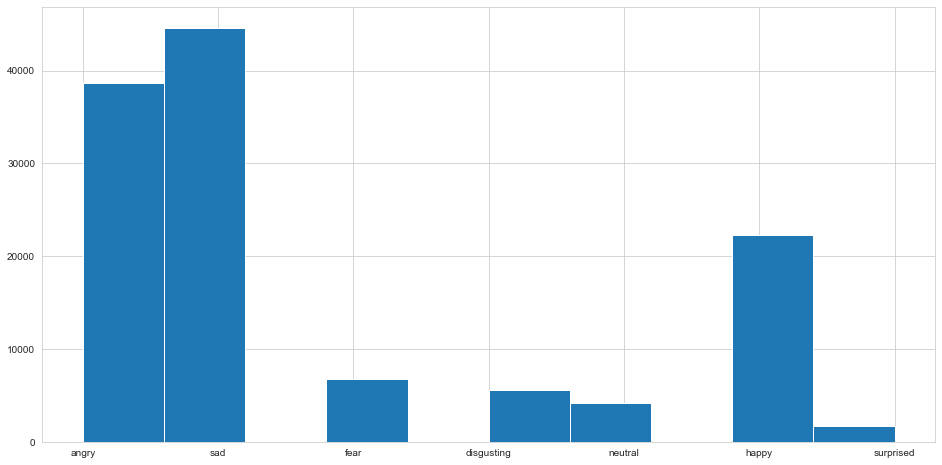

In [9]:
label = df['label']

plt.figure(figsize=(16, 8))
plt.hist(label)
plt.show()

### Train, Test split

In [10]:
X = df.text
y = df.label

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=34, stratify=y
)

In [11]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('\nX_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (99018,)
y_train shape:  (99018,)

X_test shape:  (24755,)
y_test shape:  (24755,)


## Train Data PreProcessing

### Kkma을 이용한 품사(불용어) 제거 및 토큰화

In [14]:
def preprocessing(text, kkma, remove_stopwords=False, stop_words=[]):
    # 함수의 인자는 다음과 같다.
    # text: 전처리할 텍스트
    # okt: okt객체를 반복적으로 생성하지 않고 미리 생성한 후 인자로 받는다.
    # remove_stopwords: 불용어를 제거할지 여부 선택. 기본값은 False
    # stop_words: 불용어 사전은 사용자가 직접 입력.

    # 1. 한글 및 공백을 제외한 문자를 모두 제거
    text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", text)

    # 2. okt 객체를 활용하여 형태소 단위로 나눈다
    word_text = kkma.morphs(text)

    if remove_stopwords:
        word_text = [token for token in word_text if not token in stop_words and len(token) > 1]

    return word_text

In [15]:
stop_words = set(['은', '는', '이', '가', '하', '아', '것', '들', '의', '있', '되', '수', '보', '주', '등', '한'])
kkma = Kkma()
clean_train_text = []

for text in tqdm(X_train):
    # 비어있는 데이터에서 멈추지 않도록 문자열인 경우에만 진행
    if type(text) == str:
        clean_train_text.append(preprocessing(text, kkma, remove_stopwords=True, stop_words=stop_words))
    else:
        clean_train_text.append([]) #string이 아니면 비어있는 값 추가

clean_train_text[:5]

100%|██████████| 99018/99018 [14:23<00:00, 114.64it/s]


[['급여', '차감', '니까', '짜증', '회사', '에서'],
 ['으면서', '청소', '매일', '혼자', '청소'],
 ['고맙', '이상', '없다', '기쁘'],
 ['그리하', '여도', '공지', '도록', '말씀', '드릴려'],
 ['이번', '건강', '검진', '이상']]

## Test Data PreProcessing

### Kkma을 이용한 품사(불용어) 제거 및 토큰화

In [16]:
clean_test_text = []

for text in tqdm(X_test):
    # 비어있는 데이터에서 멈추지 않도록 문자열인 경우에만 진행
    if type(text) == str:
        clean_test_text.append(preprocessing(text, kkma, remove_stopwords=True, stop_words=stop_words))
    else:
        clean_test_text.append([]) #string이 아니면 비어있는 값 추가

clean_test_text[:3]

100%|██████████| 24755/24755 [03:44<00:00, 110.41it/s]


[['텔레비전',
  '리모컨',
  '기능',
  '사람',
  '알려주',
  '어도',
  '무슨',
  'ㄴ지',
  '이해',
  '못하',
  '어서',
  '많이',
  '부끄럽'],
 ['고맙', '밖에'],
 ['구들',
  '이랑',
  '싸우',
  '선생님',
  '내가',
  '따돌림',
  '당하',
  '다고',
  '오해',
  '자꾸',
  '상담',
  '실로',
  '오래']]

### 토큰 데이터 벡터화(토큰을 숫자로 변환하고 tokenizer를 파일에 저장)

In [23]:
tokenizer_name = 'tokenizer.pickle'
save_path = os.path.join(SAVE_DIR, tokenizer_name)

tokenizer = Tokenizer(oov_token = True)

try:
    tokenizer.fit_on_texts(clean_train_text)
    train_sequences = tokenizer.texts_to_sequences(clean_train_text)
    test_sequences = tokenizer.texts_to_sequences(clean_test_text)
except:
    print('Already tokenized')

with open(save_path, 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

vocab_size = len(tokenizer.word_index)+1 # 단어의 수
vocab_size

train_sequences[:5]

[[1511, 7051, 28, 116, 19, 8],
 [435, 162, 155, 77, 162],
 [110, 196, 427, 122],
 [31, 150, 3109, 455, 352, 6083],
 [45, 39, 295, 196]]

In [24]:
# tokenizer.word_index

### Padding

리뷰의 최대 길이 : 35
리뷰의 평균 길이 : 7.112716879759236


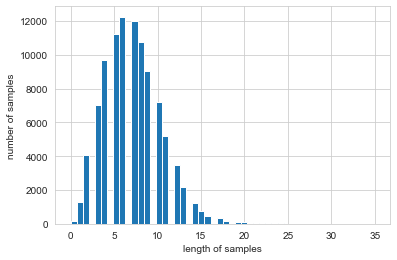

In [25]:
print('텍스트의 최대 길이 :',max(len(text) for text in train_sequences))
print('텍스트의 평균 길이 :',sum(map(len, train_sequences))/len(train_sequences))
plt.hist([len(text) for text in train_sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [28]:
trunc_type = 'post'
padding_type = 'post'
MAX_LEN = 10

X_train = pad_sequences(train_sequences, maxlen=MAX_LEN, padding=padding_type, truncating=trunc_type)
X_test= pad_sequences(test_sequences, maxlen=MAX_LEN, padding=padding_type, truncating=trunc_type)

In [29]:
print(X_train[:5])

[[1511 7051   28  116   19    8    0    0    0    0]
 [ 435  162  155   77  162    0    0    0    0    0]
 [ 110  196  427  122    0    0    0    0    0    0]
 [  31  150 3109  455  352 6083    0    0    0    0]
 [  45   39  295  196    0    0    0    0    0    0]]


### Labeling

In [30]:
y_train.unique()

array(['sad', 'angry', 'happy', 'disgusting', 'neutral', 'fear',
       'surprised'], dtype=object)

In [31]:
emo_dic = {
    'angry': 0, 'sad': 1, 'fear': 2, 'disgusting': 3, 'neutral': 4, 'happy': 5, 'surprised': 6
}

In [32]:
y_train = y_train.replace(emo_dic)
y_test = y_test.replace(emo_dic)
y_train.unique()

array([1, 0, 5, 3, 4, 2, 6])

## Model definition

In [33]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, mask_zero=True, input_length=MAX_LEN))
model.add(Dropout(DROP_OUT))
model.add(Conv1D(NUM_FILTERS, KERNEL_SIZE, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(HIDDEN_UNITS, activation='relu'))
model.add(Dropout(DROP_OUT))
model.add(Dense(OUTPUT, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=VERBOSE, patience=PATIENCE)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=VERBOSE, save_best_only=True)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Metal device set to: Apple M1


2022-07-14 09:45:46.600301: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-14 09:45:46.600406: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Train Model

In [34]:
history = model.fit(
    X_train, y_train, epochs=EPOCHS, callbacks=[es, mc], batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT
)

Epoch 1/20


2022-07-14 09:45:50.014661: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-14 09:45:50.240432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


155/155 [==============================] - ETA: 0s - loss: 1.2983 - accuracy: 0.4837

2022-07-14 09:45:58.426564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.63038, saving model to best_model.h5
155/155 [==============================] - 9s 54ms/step - loss: 1.2983 - accuracy: 0.4837 - val_loss: 0.9918 - val_accuracy: 0.6304
Epoch 2/20
155/155 [==============================] - ETA: 0s - loss: 0.8902 - accuracy: 0.6672
Epoch 2: val_accuracy improved from 0.63038 to 0.67052, saving model to best_model.h5
155/155 [==============================] - 8s 50ms/step - loss: 0.8902 - accuracy: 0.6672 - val_loss: 0.8636 - val_accuracy: 0.6705
Epoch 3/20
155/155 [==============================] - ETA: 0s - loss: 0.7751 - accuracy: 0.7081
Epoch 3: val_accuracy improved from 0.67052 to 0.67345, saving model to best_model.h5
155/155 [==============================] - 8s 51ms/step - loss: 0.7751 - accuracy: 0.7081 - val_loss: 0.8437 - val_accuracy: 0.6734
Epoch 4/20
155/155 [==============================] - ETA: 0s - loss: 0.7032 - accuracy: 0.7366
Epoch 4: val_accuracy did not improve from 0.67345
155/155 [

## Test Model

In [35]:
loaded_model = load_model('best_model.h5')
loss, acc = loaded_model.evaluate(X_test, y_test)

print('Test loss:', loss)
print('Test accuracy:', acc)

 14/774 [..............................] - ETA: 6s - loss: 0.9192 - accuracy: 0.6585

2022-07-14 09:46:58.658950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


774/774 [==============================] - 6s 7ms/step - loss: 0.8363 - accuracy: 0.6755
Test loss: 0.8363134860992432
Test accuracy: 0.6755403280258179


### Visualization

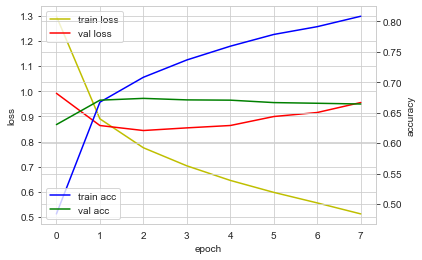

In [36]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## Save Model

In [37]:
model_name = 'trained_model.h5'

# Save model and weights
model_path = os.path.join(SAVE_DIR, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/inseoklee/Desktop/miso/model/TEST_kkma/trained_model.h5 


## Evaluation

### confusion matrix

In [38]:
y_pred = loaded_model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
print(y_pred)

 37/774 [>.............................] - ETA: 3s

2022-07-14 09:47:25.500638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


774/774 [==============================] - 3s 4ms/step
[0 1 0 ... 1 2 1]


[[5070 1851  137  121   80  465   11]
 [1405 6542  170  103   78  616   11]
 [ 161  198  879   13   13   59   33]
 [ 133  122   12  782   17   37   13]
 [ 122  156   21   10  466   54    3]
 [ 606  931   69   42   41 2756    7]
 [  12   38   27   20   10    4  228]]


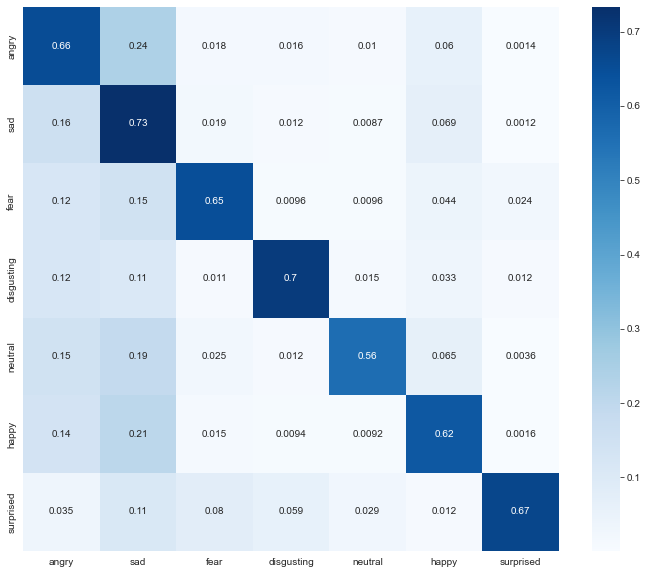

In [39]:
# constant for classes
classes = ('angry', 'sad', 'fear', 'disgusting', 'neutral', 'happy', 'surprised')

# Build confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/cf_matrix.sum(axis=1).reshape(7, 1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True, cmap='Blues')
plt.savefig(SAVE_DIR + '/output.png')

### precision, recall, f1 score

In [40]:
acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred, average='macro')
re_score = recall_score(y_test, y_pred, average='macro')
f1_score = f1_score(y_test, y_pred, average='macro')
print("accuracy_score: ", acc_score)
print("precision_score: ", prec_score)
print("recall_score: ", re_score)
print("f1_score: ", f1_score)

accuracy_score:  0.6755402948899212
precision_score:  0.6888602410649648
recall_score:  0.655588066100343
f1_score:  0.6707922353918597


## Load Model

In [41]:
def load_tokenizer(path):
    with open(path, 'rb') as f:
        tokenizer = pickle.load(f)
    return tokenizer

model_name = 'trained_model.h5'
tokenizer_name = 'tokenizer.pickle'
model_path = os.path.join(LOAD_DIR, model_name)
tokenizer_path = os.path.join(LOAD_DIR, tokenizer_name)

model = load_model(model_path)
tokenizer = load_tokenizer(tokenizer_path)


In [45]:
def getResult(predict) :
    highest = 0
    highestIdx = 0
    for x in range (0,len(predict)) :
        if(predict[x] > highest) :
            highestIdx = x
            highest =predict[x]
    return highestIdx

def predict_sentiment(text, model):
    tokens = []
    if type(text) == str:
        tokens.append(preprocessing(text, kkma, remove_stopwords=True, stop_words=stop_words))
    else:
        tokens.append([]) #string이 아니면 비어있는 값 추가
    token_sequences = tokenizer.texts_to_sequences(tokens)
    if(len(token_sequences) == 0) :
        return "너무 짧아"
    padded_sequences = pad_sequences(token_sequences, maxlen=MAX_LEN)
    predict = model.predict(padded_sequences)
    print(predict)
    result = getResult(predict[0])
    if result == 0 :
        return 'angry'
    elif result == 1 :
        return 'sad'
    elif result == 2 :
        return 'fear'
    elif result == 3 :
        return 'disgusting'
    elif result == 4 :
        return 'neutral'
    elif result == 5 :
        return 'happy'
    elif result == 6 :
        return 'surprised'

In [46]:
predict_sentiment("너 엄마가 일찍 들어오라고 했어 안했어.", model)

1/1 [==============================] - 0s 109ms/step
[[4.2568782e-01 5.4962444e-01 1.1674703e-02 2.3375289e-03 3.8528955e-03
  6.7074858e-03 1.1509295e-04]]


2022-07-14 09:47:50.425837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


'sad'

In [47]:
predict_sentiment("친구가 다쳐서 병문안 가야돼.", model)

1/1 [==============================] - 0s 15ms/step
[[0.03311667 0.00413857 0.9473682  0.00518564 0.00195766 0.00137565
  0.00685766]]


'fear'